Copyright © 2023, SAS Institute Inc., Cary, NC, USA.  All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Titanic Dataset : Assess Bias of Classification Models

This notebook provides an example of how to assess model bias for python models using the titanic dataset. The `assess_model_bias()` function featured in this notebook produces JSON files that can be uploaded into Model Manager on SAS Viya 4. Lines of code that must be modified by the user, such as directory paths or the host server are noted with the comment "_Changes required by user._".

_**Note:** If you download only this notebook and not the rest of the repository, you must also download the titanic.csv file from the data folder in the examples directory. These files are used when executing this notebook example._

Here are the steps shown in this notebook:

1. [Import Modules](#section_0)
2. [Import, review, and preprocess data for model training.](#section_1)
3. [Build, train, and assess a scikit-learn decision tree, random forest, and gradient boosting model.](#section_2)
4. [Create score tables for each model using the test data.](#section_3)
5. [Call `assess_model_bias()` to create JSON files and return relevant data frames.](#section_4)
6. [Review data frames from assess bias function and generate graphics similar to Model Studio.](#section_5)
7. [Run through steps 1-5 again but with a multi-classification model.](#section_6)

<a id='section_0'></a>

## Import Modules

In [48]:
from sasctl import Session
import sasctl.pzmm as pzmm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import getpass

<a id='section_1'></a>

## Load, Assess, and Pre-process Data

In [49]:
df_raw = pd.read_csv('data/titanic.csv')
df_raw.head()

,PassengerId,Survived,Pclass,Lname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
df_raw['Sex'].value_counts()

Sex
male      100
female     56
Name: count, dtype: int64

proportion
Sex    Survived            
female 1           0.714286
       0           0.285714
male   0           0.860000
       1           0.140000

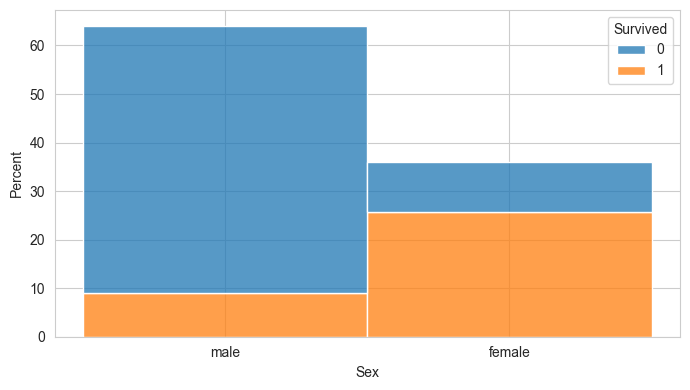

In [51]:
# summary statistics for survival by gender
sns.histplot(x=df_raw['Sex'], hue=df_raw['Survived'].astype(str), multiple="stack", stat="percent")
df_raw[['Sex', 'Survived']].groupby('Sex').value_counts(normalize=True).to_frame()

In [52]:
# pre-processing data
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df_raw[columns].dropna()
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df = df.drop(['Sex_male', 'Pclass_3', 'Embarked_S'], axis = 1)

In [53]:
df.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Pclass_1,Pclass_2,Embarked_C,Embarked_Q
0,0,22.0,1,0,7.2500,False,False,False,False,False
1,1,38.0,1,0,71.2833,True,True,False,True,False
2,1,26.0,0,0,7.9250,True,False,False,False,False
3,1,35.0,1,0,53.1000,True,True,False,False,False
4,0,35.0,0,0,8.0500,False,False,False,False,False


<a id='section_2'></a>

## Train and Assess Python Models

In [54]:
features = df.drop('Survived', axis=1).columns
target = 'Survived'

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[target], train_size=0.6, test_size=0.4,
                                                    random_state=42)

In [55]:
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

dtc.fit(X_train, Y_train)
rfc.fit(X_train, Y_train)
gbc.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

In [56]:
# Calculate the importance of a predictor
def sort_feature_importance(model, data):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, data.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + "%"
    return features

In [57]:
importances = pd.DataFrame.from_dict(sort_feature_importance(dtc, X_train), orient="index").rename(columns={0: "DecisionTree"})
importances["RandomForest"] = pd.DataFrame.from_dict(sort_feature_importance(rfc, X_train), orient="index")
importances["GradientBoosting"] = pd.DataFrame.from_dict(sort_feature_importance(gbc, X_train), orient="index")
importances

,DecisionTree,RandomForest,GradientBoosting
Sex_female,30.81%,23.55%,32.54%
Age,22.01%,25.76%,22.19%
Fare,21.69%,24.34%,20.77%
SibSp,13.67%,9.8%,17.94%
Pclass_2,8.93%,5.11%,5.01%
Pclass_1,2.89%,3.89%,0.8%
Parch,0.0%,3.29%,0.13%
Embarked_Q,0.0%,0.63%,0.23%
Embarked_C,0.0%,3.63%,0.38%


In [58]:
# assess model fit
y_dtc_predict = dtc.predict(X_test)
y_dtc_proba = dtc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_dtc_predict))
print(classification_report(Y_test, y_dtc_predict))
print("Decision Tree Model Accuracy = " + str(np.round(dtc.score(X_test, Y_test)*100,2)) + "%")

[[31  6]
 [ 8  5]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82        37
           1       0.45      0.38      0.42        13

    accuracy                           0.72        50
   macro avg       0.62      0.61      0.62        50
weighted avg       0.71      0.72      0.71        50

Decision Tree Model Accuracy = 72.0%


In [59]:
y_rfc_predict = rfc.predict(X_test)
y_rfc_proba = rfc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_rfc_predict))
print(classification_report(Y_test, y_rfc_predict))
print("Random Forest Model Accuracy = " + str(np.round(rfc.score(X_test, Y_test)*100,2)) + "%")

[[35  2]
 [10  3]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.85        37
           1       0.60      0.23      0.33        13

    accuracy                           0.76        50
   macro avg       0.69      0.59      0.59        50
weighted avg       0.73      0.76      0.72        50

Random Forest Model Accuracy = 76.0%


In [60]:
y_gbc_predict = gbc.predict(X_test)
y_gbc_proba = gbc.predict_proba(X_test)
print(confusion_matrix(Y_test, y_gbc_predict))
print(classification_report(Y_test, y_gbc_predict))
print("Gradient Boosting Model Accuracy = " + str(np.round(gbc.score(X_test, Y_test)*100,2)) + "%")

[[33  4]
 [ 9  4]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        37
           1       0.50      0.31      0.38        13

    accuracy                           0.74        50
   macro avg       0.64      0.60      0.61        50
weighted avg       0.71      0.74      0.72        50

Gradient Boosting Model Accuracy = 74.0%


<a id='section_3'></a>

## Create Score Tables

In [61]:
# recreating sex variable
sex = X_test['Sex_female'].apply(lambda x: 'female' if x else 'male')

In [62]:
dtc.classes_

array([0, 1], dtype=int64)

In [63]:
def build_score_table(model):
    score_data = {'P_Survived1': model.predict_proba(X_test)[:,1],
                  'P_Survived0': model.predict_proba(X_test)[:,0],
                  'Survived': Y_test.to_numpy(),
                  'Sex': sex}
    data = pd.DataFrame(score_data)
    return data

In [64]:
score_tables = {"DecisionTree": build_score_table(dtc),
                "RandomForest": build_score_table(rfc),
                "GradientBoost": build_score_table(gbc)}

In [65]:
for k,v in score_tables.items():
    print(f'{k} \n {v.head()}')

DecisionTree 
     P_Survived1  P_Survived0  Survived     Sex
21          0.0          1.0         1    male
57          0.0          1.0         0    male
50          0.0          1.0         0    male
99          0.0          1.0         0    male
71          1.0          0.0         0  female
RandomForest 
     P_Survived1  P_Survived0  Survived     Sex
21         0.06         0.94         1    male
57         0.38         0.62         0    male
50         0.23         0.77         0    male
99         0.11         0.89         0    male
71         0.41         0.59         0  female
GradientBoost 
     P_Survived1  P_Survived0  Survived     Sex
21     0.004533     0.995467         1    male
57     0.092341     0.907659         0    male
50     0.477515     0.522485         0    male
99     0.009657     0.990343         0    male
71     0.900963     0.099037         0  female


<a id='section_4'></a>

## Using `assess_model_bias()`

In [66]:
# setting up environment
hostname = ''
username = input("Username: ")
password = getpass.getpass("Password: ") # changes required by user

sess = Session(hostname, username, password, protocol='http')

In [67]:
# Model names
model_prefix = ["DecisionTree", "RandomForest", "GradientBoost"]
# Directory location for the model files
zip_folder = [Path.cwd() / "data/BiasMetrics/titanicModels/DecisionTree/",
             Path.cwd() / "data/BiasMetrics/titanicModels/RandomForest/",
             Path.cwd() / "data/BiasMetrics/titanicModels/GradientBoost/"] # Changes required by user
model = [dtc, rfc, gbc]

In [ ]:
# creating assess bias json files and getting dataframes
assess_bias_dfs = {}

for (model, path) in zip(model_prefix, zip_folder):
    dfs = pzmm.JSONFiles.assess_model_bias(
        score_table=score_tables[model],
        actual_values='Survived', # actual classes
        sensitive_values='Sex', # variable to assess for bias, can add more as a list
        prob_values=['P_Survived1', 'P_Survived0'], # variables for predicted probabilities (classification), first class will be the target class
        levels=['1', '0'], # same order as prob_values
        json_path=path, # directory for json files, optional
        return_dataframes=True # returns group metrics, bias metrics, and max differences data frames, default is False
    )

    assess_bias_dfs[model] = dfs

<a id='section_5'></a>

## Assess Model Bias Output

### Examples of the Data Frames

In [69]:
assess_bias_dfs['RandomForest']['groupMetricsData'].head()

,INTO_EVENT,LEVEL,PREDICTED_EVENT,P_Survived0,P_Survived1,VLABEL,_DATAROLE_,_VARIABLE_,_acc_,_ase_,...,_mcll_,_misccutoff_,_miscks_,_nobs_,_rase_,_resp_,_tn_,_tnr_,_tp_,_tpr_
0,0.266667,female,0.468000,0.532000,0.468000,,TEST,Sex,0.466667,0.295813,...,0.827098,0.533333,0.266667,15.0,0.543887,0.0,4.0,0.80000,3.0,0.3
1,0.028571,male,0.180286,0.819714,0.180286,,TEST,Sex,0.885714,0.108351,...,0.377885,0.114286,0.828571,35.0,0.329168,0.0,31.0,0.96875,0.0,0.0


In [70]:
assess_bias_dfs['RandomForest']['maxDifferencesData'].head()

,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
0,female,male,P_Survived1,Average P_Survived1,,TEST,Sex,0.287714
1,male,female,P_Survived0,Average P_Survived0,,TEST,Sex,0.287714
2,female,male,TPR,True Positive Rate,,TEST,Sex,0.300000
3,female,male,FPR,False Positive Rate,,TEST,Sex,0.168750
4,male,female,TNR,True Negative Rate,,TEST,Sex,0.168750


In [71]:
assess_bias_dfs['RandomForest']['biasMetricsData'].head()

,Metric,MetricLabel,Value,Base,Compare,Note,_VARIABLE_
0,DemographicParity,Demographic Parity (Statistical Parity),0.238095,female,male,,Sex
1,PredictiveParity,Predictive Parity,0.287714,female,male,,Sex
2,EqualAccuracy,Equal Accuracy,0.419048,male,female,,Sex
3,EqualizedOdds,Equalized Odds,0.300000,female,male,The maximum TPR difference is greater than the...,Sex
4,EqualOpportunity,Equal Opportunity,0.300000,female,male,,Sex


In [72]:
gm_dtc = assess_bias_dfs['DecisionTree']['groupMetricsData']
gm_rfc = assess_bias_dfs['RandomForest']['groupMetricsData']
gm_gbc = assess_bias_dfs['GradientBoost']['groupMetricsData']

In [73]:
md_dtc = assess_bias_dfs['DecisionTree']['maxDifferencesData']
md_rfc = assess_bias_dfs['RandomForest']['maxDifferencesData']
md_gbc = assess_bias_dfs['GradientBoost']['maxDifferencesData']

### Performance Bias

The following are examples of graphs created by Model Studio using the `assess_model_bias()` output.

In [74]:
plt.rcParams["figure.figsize"] = [7, 4]
plt.rcParams["figure.autolayout"] = True

Log Loss: $$L_{log}(y|p) = -(ylog(p) + (1-y)log(1-p))$$
Log loss measures accuracy and uncertainty. Lower values indicate either higher accuracy and or higher certainty. Here, the male category has better log loss values across the board. The random forest model minimizes this difference.

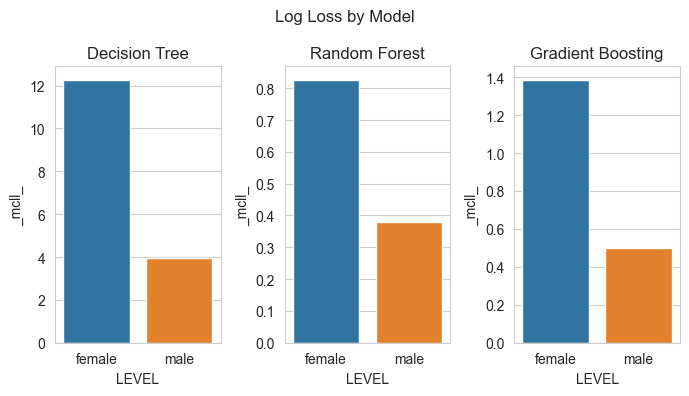

In [75]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Log Loss by Model")

sns.barplot(data=gm_dtc, x="LEVEL", y='_mcll_', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=gm_rfc, x="LEVEL", y='_mcll_', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=gm_gbc, x="LEVEL", y='_mcll_', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

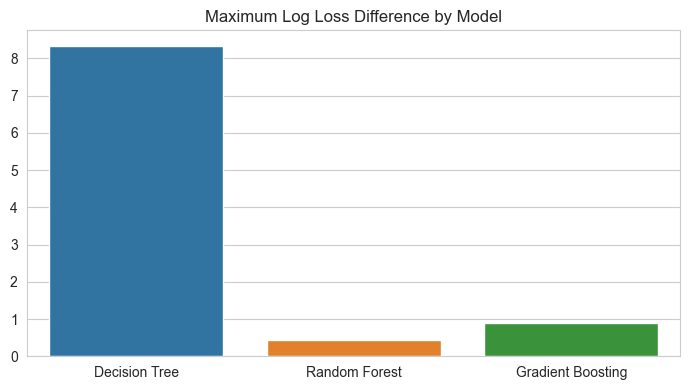

In [76]:
md_mcll = [md_dtc[md_dtc['Metric'] == 'MCLL']['maxdiff'], md_rfc[md_rfc['Metric'] == 'MCLL']['maxdiff'], md_gbc[md_gbc['Metric'] == 'MCLL']['maxdiff']]
md_mcll = [x.values[0] for x in md_mcll]
sns.barplot(x=['Decision Tree', 'Random Forest', 'Gradient Boosting'], y = md_mcll).set(title="Maximum Log Loss Difference by Model");

True Positive Rate: $$\frac{TP} {TP+FN}$$
Higher true positive rates, or sensitivity, indicate that a higher portion of observations in the positive class were correctly classified. This metric coincides with the concept of equal opportunity. Equal opportunity states that groups of people who qualify for something are accepted at equal rates to other groups. No males were predicted to survive in this example, so the true positive rate for this category is 0. The random forest model has the smallest true positive rate difference, but it also has the lowest overall true positive rate.

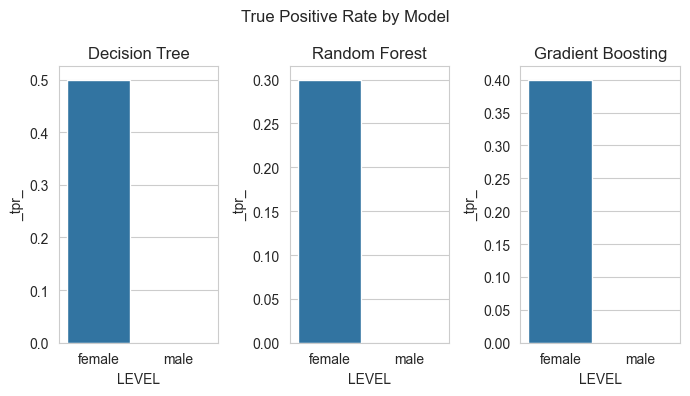

In [77]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("True Positive Rate by Model")

sns.barplot(data=gm_dtc, x="LEVEL", y='_tpr_', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=gm_rfc, x="LEVEL", y='_tpr_', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=gm_gbc, x="LEVEL", y='_tpr_', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

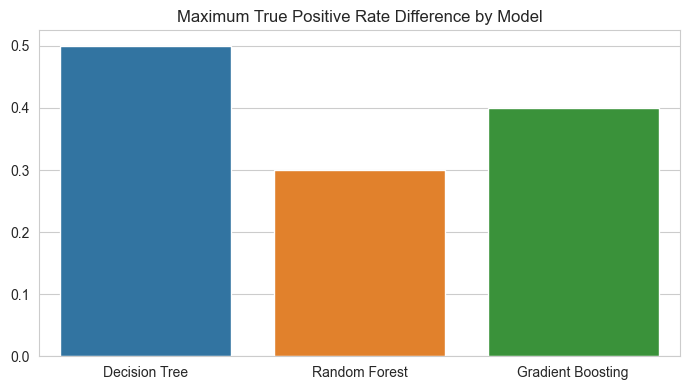

In [ ]:
md_tpr = [md_dtc[md_dtc['Metric'] == 'TPR']['maxdiff'], md_rfc[md_rfc['Metric'] == 'TPR']['maxdiff'], md_gbc[md_gbc['Metric'] == 'TPR']['maxdiff']]
md_tpr = [x.values[0] for x in md_tpr]
sns.barplot(x=['Decision Tree', 'Random Forest', 'Gradient Boosting'], y = md_tpr).set(title="Maximum True Positive Rate Difference by Model");

Max Kolmogorov-Smirnov: $$max(\mid{F_{Survive=1}(x) - F_{Survive=0}(x)\mid)$$

The maximum Kolmogorov-Smirnov statistic for binary classification problem is the maximum CDF difference between the predicted probability distributions of each level of the target variable. Higher values indicate that a binary classification model is more capable of distinguishing between the two classes. Except for the decision tree model, the models are better at distinguishing survival and death for females compared to males. The decision tree classifier minimizes the max ks difference between the two groups, but it also has the worst possible ks score.

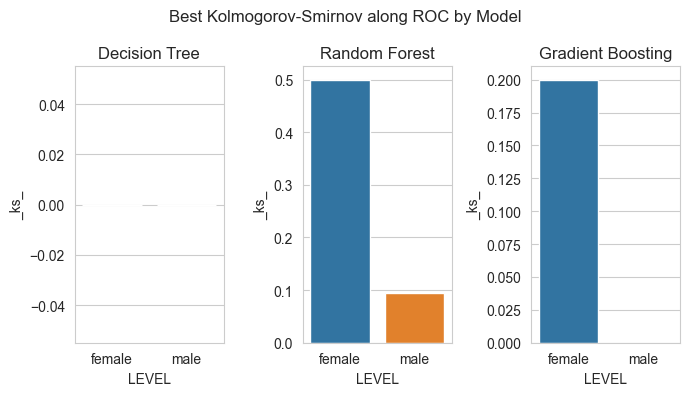

In [79]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Best Kolmogorov-Smirnov along ROC by Model")

sns.barplot(data=assess_bias_dfs['DecisionTree']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=assess_bias_dfs['RandomForest']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=assess_bias_dfs['GradientBoost']['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

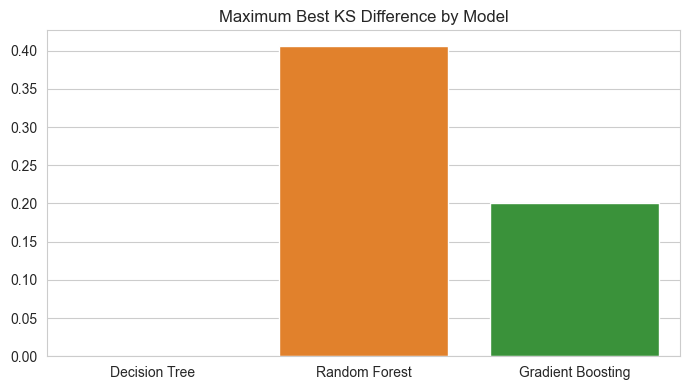

In [80]:
md_ks = [md_dtc[md_dtc['Metric'] == 'maxKS']['maxdiff'], md_rfc[md_rfc['Metric'] == 'maxKS']['maxdiff'], md_gbc[md_gbc['Metric'] == 'maxKS']['maxdiff']]
md_ks = [x.values[0] for x in md_ks]
sns.barplot(x=['Decision Tree', 'Random Forest', 'Gradient Boosting'], y = md_ks).set(title="Maximum Best KS Difference by Model");

### Average Prediction for Event

The predicted event metric is the average predicted probability of the target class. The metric coincides with the concept of predictive parity where ideally each group has the same probability of an event. In this case, the event of interest is survival and the female category has a much higher predicted probability of surviving. The random forest model produces the lowest difference.

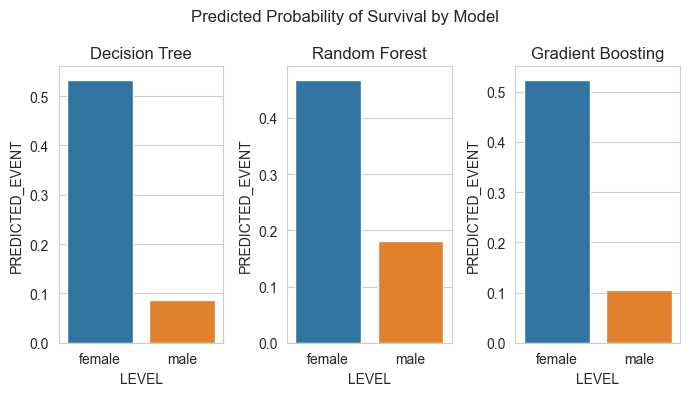

In [81]:
fig, axes = plt.subplots(1, 3)
fig.suptitle("Predicted Probability of Survival by Model")

sns.barplot(data=assess_bias_dfs['DecisionTree']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[0]).set(title="Decision Tree")
sns.barplot(data=assess_bias_dfs['RandomForest']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[1]).set(title="Random Forest")
sns.barplot(data=assess_bias_dfs['GradientBoost']['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT', ax=axes[2]).set(title="Gradient Boosting")

plt.show()

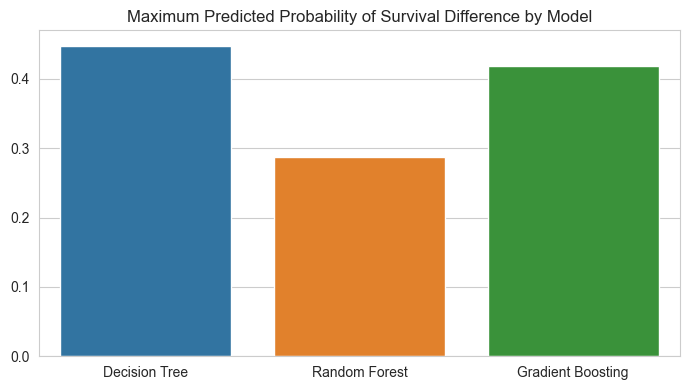

In [82]:
md_pe = [md_dtc[md_dtc['Metric'] == 'PREDICTED_EVENT']['maxdiff'], md_rfc[md_rfc['Metric'] == 'PREDICTED_EVENT']['maxdiff'], md_gbc[md_gbc['Metric'] == 'PREDICTED_EVENT']['maxdiff']]
md_pe = [x.values[0] for x in md_pe]
sns.barplot(x=['Decision Tree', 'Random Forest', 'Gradient Boosting'], y = md_pe).set(title="Maximum Predicted Probability of Survival Difference by Model");

<a id='section_6'></a>

## Multi-classification Example
This section provides a quick overview for how to assess bias on a multi-classification model and the corresponding outputs. This example will also use the titanic dataset.

### Load and Pre-process Data

In [83]:
df_raw.head()

,PassengerId,Survived,Pclass,Lname,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df_raw[columns].dropna()
df = pd.get_dummies(df, columns=['Sex', 'Embarked'])
df['Survived'] = df['Survived'].astype(str)

In [85]:
df = df.drop(['Sex_male', 'Embarked_S'], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q
0,0,3,22.0,1,0,7.2500,False,False,False
1,1,1,38.0,1,0,71.2833,True,True,False
2,1,3,26.0,0,0,7.9250,True,False,False
3,1,1,35.0,1,0,53.1000,True,False,False
4,0,3,35.0,0,0,8.0500,False,False,False


### Train Python Model

In [86]:
features = df.drop('Pclass', axis=1).columns
target = 'Pclass'

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[target], train_size=0.6, test_size=0.4,
                                                    random_state=42)

In [87]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

### Assess Model

In [88]:
pd.DataFrame.from_dict(sort_feature_importance(rfc, X_train), orient="index").rename(columns={0: "RandomForest"})

,RandomForest
Fare,53.18%
Age,21.58%
SibSp,6.94%
Parch,4.84%
Survived,4.75%
Embarked_C,4.18%
Sex_female,3.65%
Embarked_Q,0.88%


### Creating Score Table

In [89]:
# recreating sex variable
sex = X_test['Sex_female'].apply(lambda x: 'female' if x else 'male')

In [90]:
rfc.classes_

array([1, 2, 3], dtype=int64)

In [91]:
score_data = {'P_Pclass1': rfc.predict_proba(X_test)[:,0],
              'P_Pclass2': rfc.predict_proba(X_test)[:,1],
              'P_Pclass3': rfc.predict_proba(X_test)[:,2],
              'Pclass': Y_test.to_numpy(),
              'Sex': sex}
score_table = pd.DataFrame(score_data)

In [92]:
score_table.head()

,P_Pclass1,P_Pclass2,P_Pclass3,Pclass,Sex
21,0.10,0.45,0.45,2,male
57,0.09,0.22,0.69,3,male
50,0.22,0.21,0.57,3,male
99,0.07,0.79,0.14,2,male
71,0.35,0.15,0.50,3,female


### Using `assess_model_bias()`

In [ ]:
# creating assess bias json files and getting dataframes
dfs = pzmm.JSONFiles.assess_model_bias(
        score_table=score_table,
        actual_values='Pclass',
        sensitive_values='Sex',
        prob_values=['P_Pclass1', 'P_Pclass2', 'P_Pclass3'],
        levels=['1', '2', '3'],
        json_path=Path.cwd() / "data/BiasMetrics/titanicModels/MultiRandomForest/",
        return_dataframes=True
    )

### Assess Model Bias Output

In [94]:
dfs['groupMetricsData'].head()

,INTO_EVENT,LEVEL,PREDICTED_EVENT,P_Pclass1,P_Pclass2,P_Pclass3,VLABEL,_DATAROLE_,_VARIABLE_,_acc_,...,_mcll_,_misccutoff_,_miscks_,_nobs_,_rase_,_resp_,_tn_,_tnr_,_tp_,_tpr_
0,0.066667,female,0.149333,0.149333,0.340000,0.510667,,TEST,Sex,0.933333,...,0.643379,0.066667,0.200000,15.0,0.363563,50.0,13.0,1.000000,1.0,0.500
1,0.171429,male,0.225714,0.225714,0.272286,0.502000,,TEST,Sex,0.885714,...,0.527678,0.114286,0.142857,35.0,0.318224,12.5,26.0,0.962963,5.0,0.625


In [95]:
dfs['maxDifferencesData'].head()

,BASE,COMPARE,Metric,MetricLabel,VLABEL,_DATAROLE_,_VARIABLE_,maxdiff
0,male,female,P_Pclass1,Average P_Pclass1,,TEST,Sex,0.076381
1,female,male,P_Pclass2,Average P_Pclass2,,TEST,Sex,0.067714
2,female,male,P_Pclass3,Average P_Pclass3,,TEST,Sex,0.008667
3,male,female,TPR,True Positive Rate,,TEST,Sex,0.125000
4,male,female,FPR,False Positive Rate,,TEST,Sex,0.037037


In [96]:
dfs['biasMetricsData'].head()

,Metric,MetricLabel,Value,Base,Compare,Note,_VARIABLE_
0,DemographicParity,Demographic Parity (Statistical Parity),0.104762,male,female,,Sex
1,PredictiveParity,Predictive Parity,0.076381,male,female,,Sex
2,EqualAccuracy,Equal Accuracy,0.047619,female,male,,Sex
3,EqualizedOdds,Equalized Odds,0.125000,male,female,The maximum TPR difference is greater than the...,Sex
4,EqualOpportunity,Equal Opportunity,0.125000,male,female,,Sex


*Performance Bias*

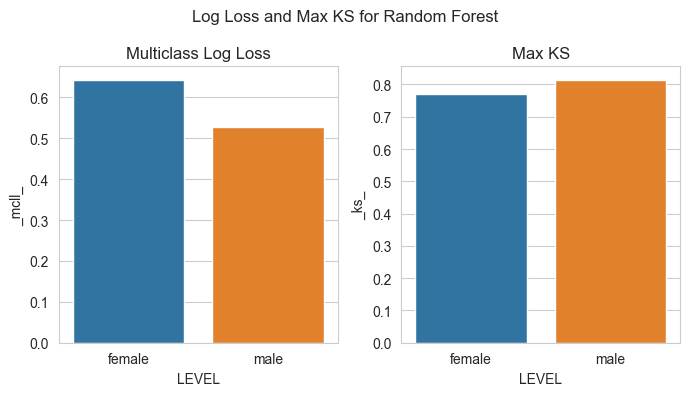

In [97]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("Log Loss and Max KS for Random Forest")

sns.barplot(data=dfs['groupMetricsData'], x="LEVEL", y='_mcll_', ax=axes[0]).set(title="Multiclass Log Loss")
sns.barplot(data=dfs['groupMetricsData'], x="LEVEL", y='_ks_', ax=axes[1]).set(title="Max KS")

plt.show()

In [98]:
md_mcll = dfs['maxDifferencesData'][dfs['maxDifferencesData']['Metric'] == 'MCLL']['maxdiff'].values[0]
md_ks = dfs['maxDifferencesData'][dfs['maxDifferencesData']['Metric'] == 'maxKS']['maxdiff'].values[0]

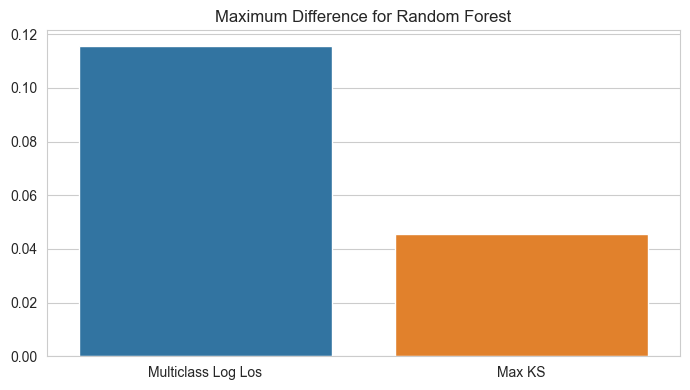

In [99]:
sns.barplot(y=[md_mcll, md_ks], x=['Multiclass Log Los', 'Max KS']).set(title="Maximum Difference for Random Forest");

*Average Prediction for Event*

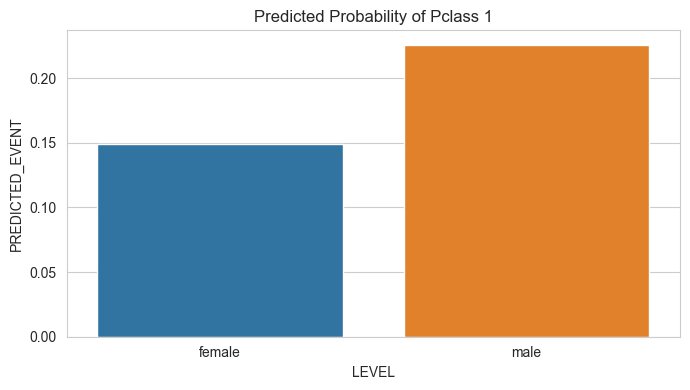

In [100]:
sns.barplot(data=dfs['groupMetricsData'], x="LEVEL", y='PREDICTED_EVENT').set(title="Predicted Probability of Pclass 1");

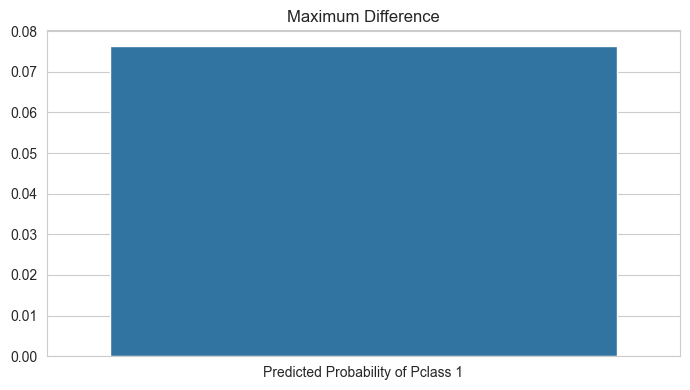

In [101]:
md_pe = dfs['maxDifferencesData'][dfs['maxDifferencesData']['Metric'] == 'PREDICTED_EVENT']['maxdiff'].values[0]
sns.barplot(y=[md_pe], x=['Predicted Probability of Pclass 1']).set(title="Maximum Difference");

***